## TD3 HalfCheetah, Ant, Humanoid

* TD3 [Fujimoto, Scott, Herke van Hoof, and David Meger. "Addressing function approximation error in actor-critic methods." arXiv preprint arXiv:1802.09477 2018.](https://arxiv.org/pdf/1802.09477.pdf)
* gSDE [Smooth Exploration for Robotic Reinforcement Learning 2020](https://arxiv.org/pdf/2005.05719v2.pdf)
* Adaptive Parameter Noise - [Parameter Space Noise for Exploration 2017/2018](https://arxiv.org/abs/1706.01905)
* https://openai.com/index/better-exploration-with-parameter-noise/

### TD3 - Twin Delayed Deep Deterministic Policy Gradient

The Q-learning algorithm is commonly known to suffer from the overestimation of the value function. This overestimation can propagate through the training iterations and negatively affect the policy. This property directly motivated [Double Q-learning](https://papers.nips.cc/paper/3964-double-q-learning) and [Double DQN](https://arxiv.org/abs/1509.06461): the action selection and Q-value update are decoupled by using two value networks.

**Twin Delayed Deep Deterministic** (short for **TD3**; Fujimoto et al., 2018) applied a couple of tricks on DDPG to prevent the overestimation of the value function:

#### 1. **Clipped Double Q-learning** 

In Double Q-Learning, the action selection and Q-value estimation are made by two networks separately. In the DDPG setting, given two deterministic actors $(\mu_{\theta_1}, \mu_{\theta_2})$ with two corresponding critics $(Q_{w_1}, Q_{w_2})$, the Double Q-learning Bellman targets look like:

$$
y_1 = r + \gamma Q_{w_2}(s', \mu_{\theta_1}(s'))\\
y_2 = r + \gamma Q_{w_1}(s', \mu_{\theta_2}(s'))
$$

However, due to the slow changing policy, these two networks could be too similar to make independent decisions. As a result, for some states we will have $Q_{w_2}(s', \mu_{\theta_1}(s')) > Q_{w_1}(s', \mu_{\theta_1}(s'))$. This is problematic because $Q_{w_1}(s', \mu_{\theta_1}(s'))$ will generally overestimate the true value, and in certain areas of the state space the overestimation will be further exaggerated. The *Clipped Double Q-learning* instead uses the minimum estimation among two so as to favor underestimation bias which is hard to propagate through training:

$$
y_1 = r + \gamma \min_{i=1,2}Q_{w_i}(s', \mu_{\theta_1}(s'))\\
y_2 = r + \gamma \min_{i=1,2} Q_{w_i}(s', \mu_{\theta_2}(s'))
$$

#### 2. **Delayed update of Target and Policy Networks**

In the actor-critic model, policy and value updates are deeply coupled: Value estimates diverge through overestimation when the policy is poor, and the policy will become poor if the value estimate itself is inaccurate.

To reduce the variance, TD3 updates the policy at a lower frequency than the Q-function. The policy network stays the same until the value error is small enough after several updates. The idea is similar to how the periodically-updated target network stay as a stable objective in DQN.

#### 3. **Target Policy Smoothing**

Given a concern with deterministic policies that they can overfit to narrow peaks in the value function. The authors propose that fitting the value of a small area around the target action:

$$y = r + E_\epsilon [Q_{w'}(s', \mu_{\theta '}(s') + \epsilon)],$$

TD3 introduced a smoothing regularization strategy on the value function: adding a small amount of clipped random noises to the selected action and averaging over mini-batches.

$$
y = r + \gamma Q_{w'} (s', \mu_{\theta '}(s') + \epsilon) \\
\epsilon \sim \text{clip}(\mathcal{N}(0, \sigma), -c, +c)  \scriptstyle{\text{ ; clipped random noises.}}
$$

The added noise is clipped to keep the target close tothe original action. This approach mimics the idea of SARSA update and enforces that similar actions should have similar values.

Here is the final algorithm:

<img src="../assets/images/td3-algo.png" width="auto" height="auto"/>

### Import Modules

In [1]:
import copy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Define Model - Continuous Control

In [2]:
# Prioritize device: CUDA > MPS > CPU
def set_device():
    if torch.cuda.is_available():
        DEVICE = torch.device("cuda")
        print("CUDA is available. Using CUDA.")
    elif torch.backends.mps.is_available():
        DEVICE = torch.device("mps")
        print("MPS backend is available. Using MPS.")
    else:
        DEVICE = torch.device("cpu")
        print("Neither CUDA nor MPS is available. Using CPU.")
    return DEVICE

DEVICE = set_device()
# lets see first on cpu
DEVICE = torch.device("cpu")

def make_cnn(in_channels: int, feature_dim: int) -> nn.Sequential:
    """
    Return a CNN feature extractor. This is just an example (Atari-style).
    Expects input shape: (B, in_channels, 84, 84).
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, feature_dim),
        nn.ReLU()
    )

def make_mlp(input_dim: int, output_dim: int, hidden_layers=[400,300], layer_norm=False) -> nn.Sequential:
    """
    Return an MLP (fully-connected) feature extractor.
    """
    layers = OrderedDict()
    layer_idx = 0
        
    for size in hidden_layers:
        # Add a linear layer
        layers[f"linear_{layer_idx}"] = nn.Linear(input_dim, size)
        layer_idx += 1
        # Add layer normalization
        if layer_norm:
            layers[f"layer_norm_{layer_idx}"] = nn.LayerNorm(size)
            layer_idx += 1
        # Add activation
        layers[f"relu_{layer_idx}"] = nn.ReLU()
        layer_idx += 1

        input_dim = size

    # Add the final output layer
    layers[f"linear_{layer_idx}"] = nn.Linear(input_dim, output_dim)
    return nn.Sequential(layers)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, obs_shape, action_size, action_low, action_high, layer_norm=False):
        """"
        :param obs_shape: Tuple describing observation (e.g. (4,84,84) for images, or (24,) for vectors)
        :param action_size: Dimension of the action space (continuous)
        :param action_low:  Lower bound for the action (float or array)
        :param action_high: Upper bound for the action (float or array)
        """
        super(Actor, self).__init__()

        # Check whether obs is an image or a vector
        if len(obs_shape) == 3:
            # e.g. obs_shape = (channels, height, width)
            in_channels = obs_shape[0]
            self.base = make_cnn(in_channels, 512)   # => feature dim = 256 (example)
            self.fc_actor = make_mlp(512, action_size, [512], layer_norm)
        else:
            # e.g. obs_shape = (state_dim,)
            state_dim = obs_shape[0]
            self.base = nn.Identity()
            self.fc_actor = make_mlp(state_dim, action_size, [400,300], layer_norm)

        # Action scaling
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2, dtype=torch.float32)
        )
        # print(self.action_scale)
        # print(self.action_bias)


    def forward(self, obs:torch.Tensor) -> torch.Tensor:
        """
        Forward pass: obs -> (CNN or Identity) -> MLP -> raw action -> scaled action
        """
        features = self.base(obs)
        action = F.tanh(self.fc_actor(features))
        return action * self.action_scale + self.action_bias


class Critic(nn.Module):
    """Double Critic (Q-Value) Model.."""

    def __init__(self, obs_shape, action_size):
        """         
        :param obs_shape: Tuple describing observation (e.g. (4,84,84) for images, or (24,) for vectors)
        :param action_size: Dimension of the action space (continuous)
        """
        super(Critic, self).__init__()
        
        # Check whether obs is an image or a vector
        if len(obs_shape) == 3:
            # e.g. obs_shape = (channels, height, width)
            in_channels = obs_shape[0]
            self.base = make_cnn(in_channels, 512)   # => feature dim = 256 (example)
            self.fc_critic1 = make_mlp(512 + action_size, 1, [512])
            self.fc_critic2 = make_mlp(512 + action_size, 1, [512])
        else:
            # e.g. obs_shape = (state_dim,)
            state_dim = obs_shape[0]
            self.base = nn.Identity()
            self.fc_critic1 = make_mlp(state_dim + action_size, 1, [400,300])
            self.fc_critic2 = make_mlp(state_dim + action_size, 1, [400,300])

    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: obs -> (CNN or Identity) -> MLP -> value1, value2
        """
        features = self.base(obs)
        feature_actions = torch.cat([features, action], dim=-1)
        value1 = self.fc_critic1(feature_actions)
        value2 = self.fc_critic2(feature_actions)
        return value1, value2 
    
    def forward_critic1(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: obs -> (CNN or Identity) -> MLP -> value1
        """
        features = self.base(obs)
        value1 = self.fc_critic1(torch.cat([features, action], dim=-1))
        return value1 

MPS backend is available. Using MPS.


#### Define noises

In [3]:
class ActionNoise(object):

    def sample(slef):
        pass

    def reset(self):
        pass

    @property
    def scale(self):
        """Get the current scale of the noise."""
        return self._scale

    @scale.setter
    def scale(self, value: float):
        """
        Set the scale of the noise.
        :param value: New scale value.
        """
        if value <= 0:
            raise ValueError("Scale must be a positive value.")
        self._scale = value
    
    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, value: torch.device):
        if not isinstance(value, torch.device):
            raise ValueError("Device must be a torch device")
        self._device = value


# https://spinningup.openai.com/en/latest/algorithms/ddpg.html#exploration-vs-exploitation
class NormalActionNoise(ActionNoise):
    """
    Normal or Gaussian noise
    noise∼N(0,σ2)
    """

    def __init__(self, action_dim, scale:float=0.1):
        self.action_dim = action_dim
        self.scale = scale # Standard deviation of the noise
    
    def reset(self):
        pass

    def sample(self):
        return np.random.normal(0, self.scale, size=self.action_dim)

class VectorizedActionNoise:
    """
    A Vectorized action noise for parallel environments.

    :param base_noise: Noise generator to use
    :param n_envs: Number of parallel environments
    """

    def __init__(self, base_noise: ActionNoise, n_envs: int) -> None:
        self.base_noise = base_noise
        self.device = base_noise.device
        self.noises = [copy.deepcopy(self.base_noise) for _ in range(n_envs)]

    def reset(self, indices) -> None:
        """
        Reset all the noise processes, or those listed in indices.

        :param indices: The indices to reset. Default: None.
            If the parameter is None, then all processes are reset to their initial position.
        """
        if indices is None:
            indices = range(len(self.noises))

        for index in indices:
            self.noises[index].reset()

    def sample(self) -> np.ndarray:
        """
        Generate and stack the action noise from each noise object.
        """
        noise = np.stack([noise.sample() for noise in self.noises])
        return noise

#### Adaptive Parameter Noise

In [4]:
"""
From OpenAI Baselines:
https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient
    
    def perturb_actor_parameters(self, actor_local, actor_perturbed, param_name='actor.linear'):
        """
        Apply parameter noise to actor model, for exploration
        
        :param actor_local: Original actor model.
        :param actor_perturbed: Perturbed actor model.
        :param param_name: Name of parameteres to be perturbed, example layers included prefix in name 'actor.linear'
        """
        # hard copy the original actor to perturbed actor
        actor_perturbed.load_state_dict(actor_local.state_dict().copy())
        params = actor_perturbed.state_dict()
        for name in params:
            if param_name in name: # do only actor and do only linear layers
                param = params[name]
                param += torch.randn(param.shape) * self.current_stddev

    def adapt_param_noise(self, replay_memory, actor_local, actor_perturbed, mini_batch_size):
        """
        Adapt parameter noise by computing the distance between perturbed and unperturbed actions.

        :param replay_memory: Replay buffer for sampling states.
        :param actor_local: Original actor model.
        :param actor_perturbed: Perturbed actor model.
        :param mini_batch_size (int): Size of the batch for computing adaptation.
        """
        replay_data = replay_memory.sample(batch_size=mini_batch_size)

        states = replay_data['obs']
        with torch.no_grad():
            unperturbed_actions = actor_local(states)
            perturbed_actions = actor_perturbed(states)

        # Computes the distance (MSE) between actions from original and perturbed actors.
        distance = ((unperturbed_actions - perturbed_actions) ** 2).mean().item()
        # adjust the amount of noise given by param noise
        self.adapt(distance)

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

### Replay Buffer 

The replay buffer storage collects and stores the following components for each step  $𝑡$ in a batch of $𝑁$ parallel environments:
- state $s_{t}$
- actions $a_{t}$
- next state $s_{t+1}$
- rewards $r_{t+}$
- terminates $m_{t+1}$ - a binary mask to indicate if the environment is terminated (0 if active, 1 entered terminal state)
- truncates $tr_{t+1}$ - a binary mask to indicate if the environmnet was truncated due to time limitation (**important to adjust rewards to include next state value**)

At each step $𝑡$, for environment $𝑏$, the collected data is:

$$ \{s_{t,b}, a_{t,b}, r_{t+1,b}, s_{t+1}, d_{t+1,b}, tr_{t+1,b} \} $$

We use torch for storing here. 

In [5]:
class ReplayBuffer:
    """    
    Replay buffer used in off-policy algorithms like DDPG/SAC/TD3.
    
    :param obs_dim: Observation dimensions
    :param action_dim: Actions dimensions
    :param n_envs: Number of parallel environments 
    :param size: Max number of elements in the buffer
    :param device: Device (cpu, cuda, ...) on which the code should be run. 
    """
    def __init__(self,
                 obs_dim,
                 action_dim:int =1,
                 n_envs: int = 1,
                 size: int = 1e6,
                 device: torch.device = torch.device("cpu")):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.device = device
        self.n_envs = n_envs

        self.pos = 0
        self.size = 0

        # Adjust buffer size 
        self.max_size = max(int(size // n_envs), 1)

        # Setup the data storage 
        self.obs = np.zeros((self.max_size, self.n_envs, *self.obs_dim), dtype=np.float32)
        self.next_obs = np.zeros((self.max_size, self.n_envs, *self.obs_dim), dtype=np.float32)
        self.actions = np.zeros((self.max_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.max_size, self.n_envs), dtype=np.float32)
        self.terminates = np.zeros((self.max_size, self.n_envs), dtype=np.int8)
        # self.truncates = np.zeros((self.size, self.n_envs), dtype=np.int8)

    def add(self,
            obs: np.ndarray,
            next_obs: np.ndarray,
            action: np.ndarray,
            reward: np.ndarray,
            terminates: np.ndarray
            ):
        self.obs[self.pos] = np.array(obs)
        self.next_obs[self.pos] = np.array(next_obs)
        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.terminates[self.pos] = np.array(terminates)

        self.pos = (self.pos + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self,
               batch_size:int = 32):
        """
        Sample elements from the replay buffer.
        
        :param batch_size: Number of elements to sample
        """
        batch_indices = np.random.randint(0, self.size, size=batch_size)
        # Sample randomly the env idx
        env_indices = np.random.randint(0, high=self.n_envs, size=(len(batch_indices),))
        # in the end we return exactly batch_size transitions collected even from different agents
        # # Extract sampled data
        # obs = self.obs[batch_indices, env_indices, :]
        # next_obs = self.next_obs[batch_indices, env_indices, :]
        # actions = self.actions[batch_indices, env_indices]
        # rewards = self.rewards[batch_indices, env_indices]
        # dones = self.dones[batch_indices, env_indices]
        
        # # Convert to torch.Tensor and return as a tuple
        # return (
        #     self._to_torch(obs),
        #     self._to_torch(next_obs),
        #     self._to_torch(actions),
        #     self._to_torch(rewards),
        #     self._to_torch(dones),
        # )
        data = dict(
            obs=self.obs[batch_indices, env_indices, :],
            next_obs=self.next_obs[batch_indices, env_indices, :],
            actions=self.actions[batch_indices, env_indices],
            rewards=self.rewards[batch_indices, env_indices],
            # Only use dones that are not due to timeouts
            dones=self.terminates[batch_indices, env_indices]
        )
        return {k: self._to_torch(v) for k,v in data.items()}
        

    def _to_torch(self, data):
        return torch.tensor(data, dtype=torch.float32, device=self.device)
    
    def __len__(self):
        return self.size

### TD3 Agent

In [6]:
from collections import deque
import time
import os

from helpers.utils import Logger


class TD3Agent:
    """
    Twin Delayed Deep Deterministic Policy Gradient (TD3)
    :param env(gym.vector.VectorEnv): Vector Gym Environment to learn from, consists of nEnvs
    :param buffer_size: size of the replay buffer
    :param mini_batch_size: Minibatch size for each gradient update
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 
            θ_target = τ*θ_local + (1 - τ)*θ_target
    :param gamma: Discount factor
    :param action_noise: the action noise type (None by default), exploration 
    :param param_noise: the adaptive param noise, exploration 
    :param policy_delay: Policy and target networks will only be updated once every policy_delay steps
            per training steps. The Q values will be updated policy_delay more often (update every training step).
    :param target_policy_noise: Standard deviation of Gaussian noise added to target policy
            (smoothing noise)
    :param target_noise_clip: Limit for absolute value of target policy smoothing noise.
    :param actor_lr: The learning rate for Actor(policy)
    :param critic_lr: The learning rate for Critic(Q-value)
    :param clip_value_loss: Whether clip value loss
        This is a parameter specific to the OpenAI implementation. 
    :param learning_starts:  how many steps of the model to collect transitions for before learning starts
    :param device: Device (cpu, cuda, ...) on which the code should be run.
    """
    def __init__(self,
                env: gym.vector.VectorEnv,
                buffer_size: int = 1e6,
                mini_batch_size: int = 128,
                tau: float = 0.005,
                learning_starts: int = 25000,
                action_noise: ActionNoise = None,
                param_noise: AdaptiveParamNoiseSpec = None,
                gamma: float = 0.99,
                policy_delay: int = 2,
                target_policy_noise: float = 0.2,
                target_noise_clip: float = 0.5,
                actor_lr: float = 1e-4,
                critic_lr: float = 1e-3,
                layer_norm: bool = False,
                device: torch.device = torch.device("cpu"),
                reward_to_achieve: int = 2500):
    
        self.env = env
        self.n_envs = env.num_envs

        self.mini_batch_size = mini_batch_size
        self.learning_starts = learning_starts
        
        self.tau = tau
        self.gamma = gamma    
        self.policy_delay = policy_delay

        self.action_noise = action_noise
        self.param_noise = param_noise

        self.device = device 

        action_size = self.env.single_action_space.shape[0]
        obs_shape = self.env.single_observation_space.shape 
        action_low = self.env.single_action_space.low 
        action_high = self.env.single_action_space.high 
        
        self.action_min = self.env.single_action_space.low[0]
        self.action_max = self.env.single_action_space.high[1]

        # Scale initially the policy noise and noise clip, sometimes its [-1,1], sometimes [-0.4,0.4], 
        # need to scale it to make rest of code work perfectly 
        action_scale = float((self.action_max - self.action_min)/2)
        self.target_policy_noise = float(target_policy_noise*action_scale)
        self.target_noise_clip = float(target_noise_clip*action_scale)
        print(action_scale, self.target_policy_noise, self.target_noise_clip)

        # initialize networks
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(obs_shape, action_size, action_low, action_high, layer_norm).to(self.device)
        self.actor_target = Actor(obs_shape, action_size, action_low, action_high, layer_norm).to(self.device)
        # hard copy the original actor to target actor
        self.actor_target.load_state_dict(self.actor_local.state_dict())
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=actor_lr)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(obs_shape, action_size).to(self.device)
        self.critic_target = Critic(obs_shape, action_size).to(self.device)
        # hard copy the original actor to target actor
        self.critic_target.load_state_dict(self.critic_local.state_dict())
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=critic_lr)
        
        if param_noise is not None:
            self.param_noise = param_noise
            self.param_noise.current_stddev *= self.param_noise.current_stddev * action_scale
            self.param_noise.desired_action_stddev *= self.param_noise.desired_action_stddev * action_scale
            self.actor_perturbed = Actor(obs_shape, action_size, action_low, action_high, layer_norm).to(self.device)            
        elif action_noise is not None:
            self.action_noise = action_noise 
            self.action_noise.scale = float(self.action_noise.scale*action_scale)
            print(self.action_noise.scale)
            if self.n_envs > 1:
                self.action_noise = VectorizedActionNoise(self.action_noise, self.n_envs)
            

        # define Replay Memory 
        self.replay_memory = ReplayBuffer(
            obs_shape,
            action_size,
            n_envs=self.n_envs,
            size=buffer_size,
            device=self.device)   

        # --------- Additional Parameters to think about
        self.rollout_steps = 1

        # logger initialization 
        run_name =(
            f"actor_lr{actor_lr}"
            f"_critic_lr{critic_lr}"
            f"_gamma{gamma}"
            f"_nenvs{env.num_envs}"
            f"_batch{self.mini_batch_size}"
            f"_tau{tau}"
            f"_noise{self.action_noise.scale if action_noise is not None else 'param'}" 
            f"_{int(time.time())}"
        )

        run_name = "".join(run_name)
        self.logger = Logger(run_name=run_name, env=env.envs[0].spec.id, algo="TD3")
        # Log hyperparameters table
        hyperparams = {
            "actor_lr": actor_lr,
            "critic_lr": critic_lr,
            "gamma": gamma,
            "tau": tau,
            "buffer_size": buffer_size,
            "mini_batch_size": mini_batch_size,
            "policy_delay": policy_delay,
            "target_policy_noise": target_policy_noise,
            "target_noise_clip": target_noise_clip,
            "action_noise": self.action_noise.scale if action_noise is not None else "param",
        }
        self.logger.log_hyperparameters(hyperparams)


        self.episode_num = 1
        self.best_reward = float('-inf')
        self.reward_to_achieve = reward_to_achieve 
    

    def select_action(self, state, add_noise=True):
        # if less then learning warm up number of steps, sample randomly, suggested 10000
        if self._num_timesteps < self.learning_starts:
            return self.env.action_space.sample()

        with torch.no_grad():
            if self.param_noise is not None and add_noise:
                action = self.actor_perturbed(state)
            else: 
                action = self.actor_local(state)
       
        if self.action_noise is not None and add_noise:
            action += torch.tensor(self.action_noise.sample(), dtype=torch.float32, device=self.device)

        clipped_actions = action.cpu().numpy().clip(
            self.env.action_space.low,
            self.env.action_space.high)

        return clipped_actions

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        :param local_model: PyTorch model (weights will be copied from)
        :param target_model: PyTorch model (weights will be copied to)
        :param tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data) 
    
    def collect_rollouts(self):
        """
        Collect experiences and store them into a ``ReplayBuffer``.
        """
        obs = self._last_obs

        for _ in range(self.rollout_steps): 
        
            actions = self.select_action(
                torch.as_tensor(obs, dtype=torch.float32, device=self.device))

            next_obs, rewards, terminates, truncates, infos = self.env.step(actions) 
            
            # Updating global number of steps agent done, while learning
            self._num_timesteps += self.n_envs

            dones = (terminates | truncates)
            
            if "final_info" in infos:
                source_info = infos["final_info"]
                self._extract_episode_data(source_info.get('episode'), source_info.get('_episode'))
            
            self.replay_memory.add(
                obs,
                next_obs,
                actions,
                rewards,
                terminates
            )

            # We reset action noise for all the episode reset situations 
            # It works in case of using noise like OUNoise or etc
            for idx, done in enumerate(dones):
                if done:
                    if self.action_noise is not None:
                        kwargs = dict(indices=[idx]) if self.n_envs > 1 else {}
                        self.action_noise.reset(**kwargs)
            # update most recent 
            obs = next_obs

        # remember last obs for next rollout call
        self._last_obs = obs
    
    def learn(self):
        """
        Update policy and value parameters using given batch of experience tuples.
        noised_action = actor_target(next_state) + clipped_noise(0,scale,-c,c)
        Q1_next_target, Q2_next_target = critic1_target(next_state, noised_action), critic2_target(next_state, noised_action)
        Q_targets = r + γ * min(Q1_next_target, Q2_next_target)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        """
        self._learn_iterations += 1

        replay_data = self.replay_memory.sample(self.mini_batch_size)
        states = replay_data['obs']#[256,17]
        actions = replay_data['actions'] #[256,6]
        rewards = replay_data['rewards'].unsqueeze(-1)# [256,1]
        next_states = replay_data['next_obs'] # [256, 17]
        dones = replay_data['dones'].unsqueeze(-1)#[256,1]

        #---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models        
        with torch.no_grad():
            clipped_noise = (torch.randn_like(actions, device=self.device) * self.target_policy_noise)
            clipped_noise = torch.clamp(
                clipped_noise,
                -self.target_noise_clip, 
                self.target_noise_clip
            )

            next_actions = (self.actor_target(next_states) + clipped_noise).clamp(
                self.action_min,
                self.action_max
            )
            
            Q1_next_targets, Q2_next_targets = self.critic_target(next_states, next_actions)
            Q_next_targets = torch.min(Q1_next_targets, Q2_next_targets)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (self.gamma * (1-dones) * Q_next_targets)

        # Compute critic loss 
        Q1_expected, Q2_expected = self.critic_local(states, actions)
        Q1_loss = F.mse_loss(Q1_expected, Q_targets)
        Q2_loss = F.mse_loss(Q2_expected, Q_targets)
        critic_loss = Q1_loss + Q2_loss
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        #---------------------------- Delayed Actor Update ------------------------------ #
        actor_loss = torch.tensor(0.0)
        if self._learn_iterations % self.policy_delay:
            # Compute actor losse
            actions = self.actor_local(states)
            q1, q2 = self.critic_local.forward(states, actions)
            actor_loss = -torch.min(q1, q2).mean()


            # Minimize the loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
       
            #-------------------------- update target network ----------------------- # 
            self.soft_update(self.actor_local, self.actor_target, self.tau)
            self.soft_update(self.critic_local, self.critic_target, self.tau)

        return( 
            Q1_loss.item(),
            Q2_loss.item(),
            critic_loss.item(), 
            actor_loss.item()
        )     

    def train(self, total_timesteps: int = 1e6, eval_frequency: int = 5000, param_noise_adaption_interval: int=50):
        """
        Train the agent
        """
        obs, _ = self.env.reset()
        self._last_obs = obs

        self._num_timesteps = 0
        self._learn_iterations = 0 #used to control the policy frequency
        self.episode_rewards = deque(maxlen=20)
        self.episode_lengths = deque(maxlen=20)
        eval_frequency = (eval_frequency // self.n_envs) * self.n_envs  # Make divisible by n_envs
    
        q1_loss, q2_loss, critic_loss, actor_loss = 0.0,0.0,0.0,0.0
        while self._num_timesteps < total_timesteps:
            
            if self._num_timesteps > self.learning_starts and self.param_noise is not None:
                self.param_noise.perturb_actor_parameters(self.actor_local, self.actor_perturbed, 'fc_actor.linear')

            for _ in range(param_noise_adaption_interval):
                # Collect rollouts
                self.collect_rollouts()

                if self._num_timesteps > self.learning_starts and \
                    len(self.replay_memory) > self.mini_batch_size:
                    q1_loss, q2_loss, critic_loss, _actor_loss = self.learn()
                    # a little bit hack, to keep seeing last non_zero actor_loss
                    if _actor_loss:
                        actor_loss = _actor_loss
        
            # Adapt each epoch, param noise 
            if self.param_noise is not None:
                self.param_noise.adapt_param_noise(self.replay_memory, self.actor_local, self.actor_perturbed, self.mini_batch_size)

            # Do some logging each log_interval
            if self._num_timesteps % eval_frequency == 0:
                mean_rewards = np.mean(self.episode_rewards)
                median_rewards = np.median(self.episode_rewards)
                min_rewards = np.min(self.episode_rewards)
                max_rewards = np.max(self.episode_rewards)
                
                print(
                    "Num timesteps {}/{} Mean Length {:.1f}\n"
                    "Loss Actor {:.4f} Q1/Q2/Critic {:.4f}/{:.4f}/{:.4} \n"
                    "Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}"
                    .format(
                        self._num_timesteps, total_timesteps, np.mean(self.episode_lengths),
                        actor_loss, q1_loss, q2_loss, critic_loss,
                        len(self.episode_rewards), mean_rewards,
                        median_rewards, min_rewards, max_rewards
                    )
                )
             
        print('Saving last...')
        self._save_model('torch.model')

    def _save_model(self, filename: str):
        """Save the current model state dictionaries and normalization info to a file in logger.dir_name."""
        model_path = os.path.join(self.logger.dir_name, filename)
        
        save_data = {
            "actor": self.actor_local.state_dict(),
            "critic": self.critic_local.state_dict(),
        }

        torch.save(save_data, model_path)


    def _extract_episode_data(self, episode_data, episode_flags):
        """
        Extract data for environments where '_episode' is True and append it to 
        self.episode_info_buffer deque
            {'r': -21.0, '_r': True, 'l': 944, '_l': True, 't': 5.089006, '_t': True}- example
            r - cumulative reward
            l - episode length
            t - elapsed time since beginning of episode

        :param episode_data: dict, data from environments
        :param episode_flags: np.ndarray, boolean array indicating done environments
        """
        done_envs = np.where(episode_flags)[0]  # Get indices of done environments
    
        for env_index in done_envs:
            env_specific_data = {}
            for key, value in episode_data.items():
                if isinstance(value, np.ndarray):  # Ensure it's an array
                    env_specific_data[key] = value[env_index]
            reward = env_specific_data['r']
            length = env_specific_data['l']
            self.logger.add_scalar('reward', reward, self.episode_num)
            self.logger.add_scalar('length', length, self.episode_num)        
            self.episode_rewards.append(reward)
            self.episode_lengths.append(length)
            self.episode_num += 1
        
        #Save the best model
        mean_rewards = np.mean(self.episode_rewards)
        if  mean_rewards > self.reward_to_achieve and mean_rewards > self.best_reward:
            self.best_reward = mean_rewards
            self._save_model('best-torch.model')
            print(f"Saved best model with min rewards {mean_rewards:.2f}")
        



### Train Example - HalfCheetah-v5

Setup the envs 

In [79]:
from helpers.envs import make_sync_vec, AutoresetMode

num_envs = 1
env_id = 'HalfCheetah-v5'

envs = make_sync_vec(env_id, 
                    num_envs=num_envs, 
                    wrappers=(gym.wrappers.RecordEpisodeStatistics,),
                    autoreset_mode=AutoresetMode.SAME_STEP)

action_size = envs.single_action_space.shape[0]
DEVICE = torch.device("cpu")
# param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05, desired_action_stddev=0.2)
normal_noise = NormalActionNoise(action_size, 0.1)


agent = TD3Agent(envs,  
            learning_starts=25000,

            mini_batch_size=256,
            gamma=0.99,  
            tau=0.005,
            actor_lr=3e-4,
            critic_lr=3e-4,
            action_noise=normal_noise,
            target_policy_noise=0.2,
            target_noise_clip=0.5,
            policy_delay=2,
            layer_norm=False,
            device=DEVICE,
            reward_to_achieve=2500)

agent.train(total_timesteps=1e6, eval_frequency=10000) 

1.0 0.2 0.5
0.1
----------------------------------------------------------------------------
| Hyperparams                    | Values                                  |
----------------------------------------------------------------------------
| actor_lr                       | 0.0003                                  |
| critic_lr                      | 0.0003                                  |
| gamma                          | 0.99                                    |
| tau                            | 0.005                                   |
| buffer_size                    | 1000000.0                               |
| mini_batch_size                | 256                                     |
| policy_delay                   | 2                                       |
| target_policy_noise            | 0.2                                     |
| target_noise_clip              | 0.5                                     |
| action_noise                   | 0.1                      

### Train Example - Ant-v5

Setup the envs

In [80]:
from helpers.envs import make_sync_vec, AutoresetMode

num_envs = 1
env_id = 'Ant-v5'

envs = make_sync_vec(env_id, 
                    num_envs=num_envs, 
                    wrappers=(gym.wrappers.RecordEpisodeStatistics,),
                    autoreset_mode=AutoresetMode.SAME_STEP)

action_size = envs.single_action_space.shape[0]
DEVICE = torch.device("cpu")
# param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05, desired_action_stddev=0.2)
normal_noise = NormalActionNoise(action_size, 0.1)


agent = TD3Agent(envs,  
            learning_starts=25000,
            mini_batch_size=256,
            gamma=0.99,  
            tau=0.005,
            actor_lr=3e-4,
            critic_lr=3e-4,
            action_noise=normal_noise,
            target_policy_noise=0.2,
            target_noise_clip=0.5,
            policy_delay=2,
            layer_norm=False,
            device=DEVICE,
            reward_to_achieve=2500)

agent.train(total_timesteps=1e6, eval_frequency=10000) 

1.0 0.2 0.5
0.1
----------------------------------------------------------------------------
| Hyperparams                    | Values                                  |
----------------------------------------------------------------------------
| actor_lr                       | 0.0003                                  |
| critic_lr                      | 0.0003                                  |
| gamma                          | 0.99                                    |
| tau                            | 0.005                                   |
| buffer_size                    | 1000000.0                               |
| mini_batch_size                | 256                                     |
| policy_delay                   | 2                                       |
| target_policy_noise            | 0.2                                     |
| target_noise_clip              | 0.5                                     |
| action_noise                   | 0.1                      

### Train Example - Humanoid-v5

In [84]:
from helpers.envs import make_sync_vec, AutoresetMode

num_envs = 1
env_id = 'Humanoid-v5'

envs = make_sync_vec(env_id, 
                    num_envs=num_envs, 
                    wrappers=(gym.wrappers.RecordEpisodeStatistics,),
                    autoreset_mode=AutoresetMode.SAME_STEP)

action_size = envs.single_action_space.shape[0]
DEVICE = torch.device("cpu")
# param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05, desired_action_stddev=0.2)
normal_noise = NormalActionNoise(action_size, 0.2)


agent = TD3Agent(envs,  
            learning_starts=25000,
            mini_batch_size=256,
            gamma=0.99,  
            tau=0.005,
            actor_lr=1e-4,
            critic_lr=1e-4,
            action_noise=normal_noise,
            target_policy_noise=0.2,
            target_noise_clip=0.5,
            policy_delay=2,
            layer_norm=False,
            device=DEVICE,
            reward_to_achieve=2500)

agent.train(total_timesteps=1e6, eval_frequency=10000) 

0.4000000059604645 0.0800000011920929 0.20000000298023224
0.0800000011920929
----------------------------------------------------------------------------
| Hyperparams                    | Values                                  |
----------------------------------------------------------------------------
| actor_lr                       | 0.0001                                  |
| critic_lr                      | 0.0001                                  |
| gamma                          | 0.99                                    |
| tau                            | 0.005                                   |
| buffer_size                    | 1000000.0                               |
| mini_batch_size                | 256                                     |
| policy_delay                   | 2                                       |
| target_policy_noise            | 0.2                                     |
| target_noise_clip              | 0.5                                     |

### Evaluate, make video

In [7]:
# Import required helpers for the evaluation and video making 
from helpers.utils import create_evaluation_env_model, eval_policy, record_video

#### Best Result HalfCheetah-v5

In [10]:

env, eval_model = create_evaluation_env_model('HalfCheetah-v5', 
                                              Actor, 
                                              './runs/HalfCheetah-v5/TD3/actor_lr0.0003_critic_lr0.0003_gamma0.99_nenvs1_batch256_tau0.005_noise0.1_1740935195/best-torch.model') 

eval_policy(env, eval_model, num_episodes=10)

Episode 1: Total Reward = 7777.884517675515
Episode 2: Total Reward = 7693.718275583373
Episode 3: Total Reward = 7844.640212285394
Episode 4: Total Reward = 7751.838244559738
Episode 5: Total Reward = 7758.778457810196
Episode 6: Total Reward = 7721.703191717006
Episode 7: Total Reward = 7745.193597935449
Episode 8: Total Reward = 7815.85434896124
Episode 9: Total Reward = 7709.506961054647
Episode 10: Total Reward = 7750.98438867409
Mean Reward: 7757.010219625665, Standard Deviation: 43.922908196437724


(np.float64(7757.010219625665), np.float64(43.922908196437724))

In [11]:
record_video(env, 
             eval_model, 
             './videos', 
             'td3_halfcheetah_v5.mp4', 
             fps=60, min_reward=7700)

7517.198396755457
7709.069494753616
7798.629301945769


'./videos/td3_halfcheetah_v5.mp4'

<video width="640" height="480" controls>
  <source src="../assets/videos/td3_halfcheetah_v5.mp4" type="video/mp4">
</video>

#### Best Result Ant-v5


In [12]:
env, eval_model = create_evaluation_env_model('Ant-v5', 
                                              Actor, 
                                              './runs/Ant-v5/TD3/actor_lr0.0003_critic_lr0.0003_gamma0.99_nenvs1_batch256_tau0.005_noise0.1_1740946542/best-torch.model') 

eval_policy(env, eval_model, num_episodes=10)

Episode 1: Total Reward = 5606.63030836143
Episode 2: Total Reward = 5753.800629799539
Episode 3: Total Reward = 5690.862440667079
Episode 4: Total Reward = 5459.731703107025
Episode 5: Total Reward = 5676.736574163247
Episode 6: Total Reward = 5686.838428952641
Episode 7: Total Reward = 5971.419262065502
Episode 8: Total Reward = 5570.92557810914
Episode 9: Total Reward = 5562.196856153147
Episode 10: Total Reward = 5792.614319025099
Mean Reward: 5677.1756100403845, Standard Deviation: 135.21293705815793


(np.float64(5677.1756100403845), np.float64(135.21293705815793))

In [13]:
record_video(env, 
             eval_model, 
             './videos', 
             'td3_ant_v5.mp4', 
             fps=60, min_reward=5600)

4884.046004249101
5825.234078469128
5665.173589969115


'./videos/td3_ant_v5.mp4'

<video width="640" height="480" controls>
  <source src="../assets/videos/td3_ant_v5.mp4" type="video/mp4">
</video>

#### Best Result Humanoid-v5

In [14]:
env, eval_model = create_evaluation_env_model('Humanoid-v5', 
                                              Actor, 
                                              './runs/Humanoid-v5/TD3/actor_lr0.0001_critic_lr0.0001_gamma0.99_nenvs1_batch256_tau0.005_noise0.0800000011920929_1741003349/best-torch.model') 

eval_policy(env, eval_model, num_episodes=10)

Episode 1: Total Reward = 4980.794256247066
Episode 2: Total Reward = 5012.375757204165
Episode 3: Total Reward = 5016.422764708546
Episode 4: Total Reward = 5012.425087811564
Episode 5: Total Reward = 5002.312039432314
Episode 6: Total Reward = 5006.725333832156
Episode 7: Total Reward = 5012.731316113164
Episode 8: Total Reward = 4975.278831429372
Episode 9: Total Reward = 5010.127677489445
Episode 10: Total Reward = 4986.335624948871
Mean Reward: 5001.552868921666, Standard Deviation: 14.265620113502738


(np.float64(5001.552868921666), np.float64(14.265620113502738))

In [15]:
record_video(env, 
             eval_model, 
             './videos', 
             'td3_humanoid_v5.mp4', 
             fps=60, min_reward=5000)

5032.998577512915
4845.342665272925
4996.054708630489
5014.963667259162


'./videos/td3_humanoid_v5.mp4'

<video width="640" height="480" controls>
  <source src="../assets/videos/td3_humanoid_v5.mp4" type="video/mp4">
</video>

-----------------------------------
## OFFTOPIC
-----------------------------------

Let's review some ways to use gymnasium wrappers for out tasks, look how to setup normalized low dimensions and pixel dimension env for ours tasks, to pass to the agent to train on tasks. Thinking if actually in future define some base class with logging functionality  for all the agents I code as well. Hm, could be interesting idea actually. 

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import AddRenderObservation, TransformObservation, FrameStackObservation,\
      NumpyToTorch, RecordEpisodeStatistics, NormalizeObservation
from gymnasium import ObservationWrapper

import cv2
import numpy as np
import torch
import timeit


ENV_ID = 'HalfCheetah-v5'
device = torch.device('cpu')


def define_simple_env(env_id, device):
    env = gym.make(env_id)
    # Add record Episode Statistcs
    env = RecordEpisodeStatistics(env)
    # Add conversion of numpy data to torch 
    env = NumpyToTorch(env, device)
    # Add Normalization 
    env = NormalizeObservation(env)

    return env

def define_simple_env2(env_id, device):
    env = gym.make(env_id)
    # Add record Episode Statistcs
    env = RecordEpisodeStatistics(env)
    # Add Normalization 
    env = NormalizeObservation(env)
    # Add conversion of numpy data to torch 
    env = NumpyToTorch(env, device)

    return env

def experiment(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(10):
        obs, reward, _, _, _ = env.step(torch.empty(size=(action_dim,), dtype=torch.float32).uniform_(-1, 1))
    
    return obs, reward

env = define_simple_env(ENV_ID, device)
env2 = define_simple_env2(ENV_ID, device)

time1 = timeit.timeit(lambda: experiment(env), number=1000)
time2 = timeit.timeit(lambda: experiment(env2), number=1000)

print(f"Env1 execution: {time1:.4f} seconds")
print(f"Env2 execution: {time2:.4f} seconds") # 2x faster, better do normalize before transforming to torch, 
# too many transforms otherwise, also data of obs gets fucked otherwise returned


Env1 execution: 1.3231 seconds
Env2 execution: 0.6927 seconds


Review the data with simple env2, how it looks

In [ ]:
env = define_simple_env2(ENV_ID, device)
obs, reward = experiment(env)


print(env)
print(env.action_space)
print(env.observation_space)

print(obs)
print(reward)


<NumpyToTorch<NormalizeObservation<RecordEpisodeStatistics<TimeLimit<OrderEnforcing<PassiveEnvChecker<HalfCheetahEnv<HalfCheetah-v5>>>>>>>>
Box(-1.0, 1.0, (6,), float32)
Box(-inf, inf, (17,), float32)
tensor([-0.7766, -1.6027, -0.4736,  1.3003,  1.1561, -0.4857,  0.8846, -1.2226,
        -0.1367,  2.4390,  0.6243,  0.3367, -0.7424, -0.4265, -1.4405,  0.8717,
         0.4698])
-0.21953247910958676


Review how same will work with mps 

In [ ]:
class NumpyToTorchMPS(gym.Wrapper):
    """Converts NumPy-based environment inputs/outputs to PyTorch Tensors, with MPS compatibility."""

    def __init__(self, env: gym.Env,  device: str | torch.device = "cpu"):
        super().__init__(env)
        self.device = torch.device(device)
        self.obs_tensor = torch.zeros(env.observation_space.shape, dtype=torch.float32, device=self.device)

    def _to_torch(self, value):
        if isinstance(value, np.ndarray):
            self.obs_tensor.copy_(torch.tensor(value, dtype=torch.float32, device=self.device))
            return self.obs_tensor
        return value

    def _to_numpy(self, value):
        if isinstance(value, torch.Tensor):
            # Convert back to NumPy only when absolutely necessary
            return value.cpu().numpy()
        return value

    def reset(self, *, seed=None, options=None):
        """Resets the environment and returns PyTorch-based observations."""
        obs, info = self.env.reset(seed=seed, options=self._to_numpy(options) if options else None)
        return self._to_torch(obs), info

    def step(self, action):
        """Takes a step using a PyTorch action and returns PyTorch-based observations."""
        obs, reward, terminated, truncated, info = self.env.step(self._to_numpy(action))
        return (
            self._to_torch(obs),
            float(reward),
            bool(terminated),
            bool(truncated),
            info,
        )

def define_simple_env(env_id, device):
    env = gym.make(env_id)
    # Add record Episode Statistcs
    env = RecordEpisodeStatistics(env)
    # Add Normalization 
    env = NormalizeObservation(env)
    # Add conversion of numpy data to torch 
    env = NumpyToTorchMPS(env, device)

    return env


def define_simple_env2(env_id, device):
    env = gym.make(env_id)
    # Add record Episode Statistcs
    env = RecordEpisodeStatistics(env)
    # Add Normalization 
    env = NormalizeObservation(env)

    return env

def experiment(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(10):
        obs, reward, _, _, _ = env.step(torch.empty(size=(action_dim,), dtype=torch.float32).uniform_(-1, 1))
    
    return obs, reward

def experiment2(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(10):
        obs, reward, _, _, _ = env.step(np.random.uniform(low=-1.0, high=1.0, size=action_dim))
    
    return obs, reward

ENV_ID = 'Humanoid-v5'
device = torch.device('mps')

env = define_simple_env(ENV_ID, device)
env2 = define_simple_env2(ENV_ID, device)
env3 = define_simple_env(ENV_ID, torch.device('cpu'))
# obs, reward = experiment(env)

time1 = timeit.timeit(lambda: experiment(env), number=1000)
time2 = timeit.timeit(lambda: experiment2(env2), number=1000)
time3 = timeit.timeit(lambda: experiment(env3), number=1000)


print(f"MPS Env execution: {time1:.4f} seconds")
print(f"CPU Torch Env execution: {time3:.4f} seconds")
print(f"No torch env execution: {time2:.4f} seconds")

# print(obs)
# print(reward)


MPS Env execution: 3.5361 seconds
CPU Torch Env execution: 1.8292 seconds
No torch env execution: 1.7196 seconds


Lets do some tests now with more complex env and see how it works, like with images 

In [ ]:
import os
from gymnasium.wrappers import AddRenderObservation, FrameStackObservation,\
      NumpyToTorch, RecordEpisodeStatistics, NormalizeObservation

os.environ["MUJOCO_GL"]="glfw"
os.environ["PYOPENGL_PLATFORM"] = "glfw"


class PreprocessObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        self.observation_space = gym.spaces.Box(low=0, high=1.0, shape=(84, 84), dtype=np.float32)
    
    def observation(self, observation):
        # Convert to grayscale
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        # Resize to 84x84
        observation = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_AREA)
        # Normalize to [0, 1]
        observation = observation / 255.0
        return observation

def create_env_preprocess(env_id):
    env = gym.make(env_id, render_mode='rgb_array')
    # Change env to use render observation
    env = AddRenderObservation(env, render_only=True)
    # Add our own preprocess observation 
    env = PreprocessObservation(env)
    # print(env.observation_space)
    # Stack the last 4 frames
    env = FrameStackObservation(env, stack_size=4)
    return env

ENV_ID = 'HalfCheetah-v5'
device1 = torch.device('mps')
device2 = torch.device('cpu')

env = create_env_preprocess(ENV_ID)
# Add conversion of numpy data to torch 
envmps = NumpyToTorchMPS(env, device1)
envcpu = NumpyToTorchMPS(env, device2)


time1 = timeit.timeit(lambda: experiment(envmps), number=100)
time2 = timeit.timeit(lambda: experiment(envcpu), number=100)
time3 = timeit.timeit(lambda: experiment2(env), number=100)

print(f"MPS Pixels Env execution: {time1:.4f} seconds")
print(f"CPU Pixels Env execution: {time2:.4f} seconds")
print(f"No torch pixels env execution: {time3:.4f} seconds")

# experiment(envmps)       

MPS Pixels Env execution: 3.7894 seconds
CPU Pixels Env execution: 3.5141 seconds
No torch pixels env execution: 3.4465 seconds


Experiment with running parallel 4 env and compare data, not complext but simple HalfCheetah 

In [ ]:
from gymnasium.vector import SyncVectorEnv
from gymnasium.wrappers.vector import NumpyToTorch
from gymnasium.vector import VectorWrapper, VectorEnv
from gymnasium.core import ActType, ObsType
from gymnasium.vector.vector_env import ArrayType
from typing import Any


num_envs = 4
env_id = 'HalfCheetah-v5'
device1 = torch.device('mps')
device2 = torch.device('cpu')

os.environ["MUJOCO_GL"]="glfw"
os.environ["PYOPENGL_PLATFORM"] = "glfw"

class NumpyToTorchMPS(VectorWrapper):
    """Wraps a numpy-based vector environment so that it can be interacted with through PyTorch Tensors on MPS.
    """

    def __init__(self, env: VectorEnv, device: str | torch.device = "mps"):
        """Wrapper class to change inputs and outputs of the environment to PyTorch tensors for MPS.

        Args:
            env: The numpy-based vector environment to wrap
            device: The device (e.g., "mps") the torch Tensors should be moved to
        """
        super().__init__(env)
        self.device: torch.device = torch.device(device)

    def step(
        self, actions: ActType
    ) -> tuple[ObsType, ArrayType, ArrayType, ArrayType, dict]:
        """Converts PyTorch-based actions to NumPy and returns PyTorch-based results.

        Args:
            actions: A PyTorch-based action tensor

        Returns:
            PyTorch-based Tensor next observation, reward, termination, truncation, and extra info
        """
        # Convert PyTorch tensor actions to NumPy
        np_actions = actions.cpu().numpy()
        obs, reward, terminated, truncated, info = self.env.step(np_actions)

        # Convert results back to PyTorch tensors on MPS
        return (
            torch.as_tensor(obs, dtype=torch.float32, device=self.device),
            torch.as_tensor(reward, dtype=torch.float32, device=self.device),
            torch.as_tensor(terminated, dtype=torch.bool, device=self.device),
            torch.as_tensor(truncated, dtype=torch.bool, device=self.device),
            self._to_torch(info),
        )

    def reset(
        self,
        *,
        seed: int | list[int] | None = None,
        options: dict[str, Any] | None = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """Resets the environment and returns PyTorch-based results.

        Args:
            seed: The seed for resetting the environment
            options: The options for resetting the environment

        Returns:
            PyTorch-based observations and info
        """
        if options:
            options = self._to_numpy(options)

        # Reset environment and convert results to PyTorch tensors
        obs, info = self.env.reset(seed=seed, options=options)
        return self._to_torch(obs), self._to_torch(info)

    def _to_torch(self, value):
        """Helper function to convert NumPy values to PyTorch tensors."""
        if isinstance(value, np.ndarray):
            return torch.tensor(value, dtype=torch.float32, device=self.device)
        elif isinstance(value, dict):
            return {k: self._to_torch(v) for k, v in value.items()}
        elif isinstance(value, (list, tuple)):
            return type(value)(self._to_torch(v) for v in value)
        return value

    def _to_numpy(self, value):
        """Helper function to convert PyTorch tensors back to NumPy."""
        if isinstance(value, torch.Tensor):
            return value.cpu().numpy()
        elif isinstance(value, dict):
            return {k: self._to_numpy(v) for k, v in value.items()}
        elif isinstance(value, (list, tuple)):
            return type(value)(self._to_numpy(v) for v in value)
        return value

def create_env_preprocess_func(env_id):
        def _init():
            env = gym.make(env_id)
            # Add record Episode Statistcs
            env = RecordEpisodeStatistics(env)
            # Add Normalization 
            env = NormalizeObservation(env)
            return env
        return _init

def create_env_preprocess_func_2(env_id):
    def _init():
        env = gym.make(env_id, render_mode='rgb_array')
        # Change env to use render observation
        env = AddRenderObservation(env, render_only=True)
        # Add our own preprocess observation 
        env = PreprocessObservation(env)
        # print(env.observation_space)
        # Stack the last 4 frames
        env = FrameStackObservation(env, stack_size=4)
        return env
    return _init

def experiment(env):
    env.reset()

    action_dim = env.action_space.shape

    for i in range(10):
        obs, reward, _, _, _ = env.step(torch.empty(size=action_dim, dtype=torch.float32).uniform_(-1, 1))
    
    return obs, reward

envs1 = SyncVectorEnv([create_env_preprocess_func_2(env_id) for _ in range(num_envs)]) 
envs1 = NumpyToTorchMPS(envs1, device1)
envs2 = SyncVectorEnv([create_env_preprocess_func_2(env_id) for _ in range(num_envs)]) 
envs2 = NumpyToTorchMPS(envs2, device2)

time1 = timeit.timeit(lambda: experiment(envs1), number=100)
time2 = timeit.timeit(lambda: experiment(envs2), number=100)

print(f"MPS Pixels Env execution: {time1:.4f} seconds")
print(f"CPU Pixels Env execution: {time2:.4f} seconds") # well that's pathetic aaaa
# With HalfCheetah 6.6x perfomance gain on CPU on 4 env
# With Humanoid 5.95x perfomance gain on CPU
# With HalfCheetah 3.45x perfomance gain on CPU on 16 env
# With Humanoid 2.51x perfomance gain on CPU on 16 env
# With Humanoid 1.82x perfomance gain on CPU on 32 env
# With HalfCheetah pixels perfomace MPS 15.81 vs CPU 14.5

MPS Pixels Env execution: 15.8182 seconds
CPU Pixels Env execution: 14.5051 seconds


Experiment similar with the envs for the pixels, but use this time deepmind gym and see if its faster

In [ ]:
import numpy as np
import torch
import timeit
import cv2

from helpers import dmc2gym
import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.wrappers import FrameStackObservation

class NumpyToTorchMPS(gym.Wrapper):
    """Converts NumPy-based environment inputs/outputs to PyTorch Tensors, with MPS compatibility."""

    def __init__(self, env: gym.Env,  device: str | torch.device = "cpu"):
        super().__init__(env)
        self.device = torch.device(device)
        self.obs_tensor = torch.zeros(env.observation_space.shape, dtype=torch.float32, device=self.device)

    def _to_torch(self, value):
        if isinstance(value, np.ndarray):
            self.obs_tensor.copy_(torch.tensor(value, dtype=torch.float32, device=self.device))
            return self.obs_tensor
        return value

    def _to_numpy(self, value):
        if isinstance(value, torch.Tensor):
            # Convert back to NumPy only when absolutely necessary
            return value.cpu().numpy()
        return value

    def reset(self, *, seed=None, options=None):
        """Resets the environment and returns PyTorch-based observations."""
        obs, info = self.env.reset(seed=seed, options=self._to_numpy(options) if options else None)
        return self._to_torch(obs), info

    def step(self, action):
        """Takes a step using a PyTorch action and returns PyTorch-based observations."""
        obs, reward, terminated, truncated, info = self.env.step(self._to_numpy(action))
        return (
            self._to_torch(obs),
            float(reward),
            bool(terminated),
            bool(truncated),
            info,
        )

class PreprocessObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        self.observation_space = gym.spaces.Box(low=0, high=1.0, shape=(84, 84), dtype=np.float32)
    
    def observation(self, observation):
        # print(observation.shape)
        # Convert to grayscale
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        # Normalize to [0, 1]
        observation = observation / 255.0
        return observation

def experiment(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(10):
        obs, reward, _, _, _ = env.step(torch.empty(size=(action_dim,), dtype=torch.float32).uniform_(-1, 1))
    
    return obs, reward

def experiment2(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(10):
        obs, reward, _, _, _ = env.step(np.random.uniform(low=-1.0, high=1.0, size=action_dim))
    
    return obs, reward
# print(suite.ALL_TASKS)

env = dmc2gym.DMCWrapper(domain_name="cheetah", task_name="run", rendering='egl', frame_skip=4, from_pixels=True, height=84, width=84)
env = PreprocessObservation(env)
env = FrameStackObservation(env, stack_size=4)
device1 = torch.device('mps')
device2 = torch.device('cpu')

# Add conversion of numpy data to torch 
envmps = NumpyToTorchMPS(env, device1)
envcpu = NumpyToTorchMPS(env, device2)

time1 = timeit.timeit(lambda: experiment(envmps), number=100)
time2 = timeit.timeit(lambda: experiment(envcpu), number=100)
time3 = timeit.timeit(lambda: experiment2(env), number=100)

print(f"MPS Pixels Env execution: {time1:.4f} seconds")
print(f"CPU Pixels Env execution: {time2:.4f} seconds")
print(f"No torch pixels env execution: {time3:.4f} seconds")
#MPS Pixels Env execution: 3.7953 seconds  vs 3.20 -> 18% improvement
# CPU Pixels Env execution: 3.4143 seconds vs 2.97 -> 15% improvement
# No torch pixels env execution: 3.4137 seconds vs 2.96 -> 15% improvement

MPS Pixels Env execution: 3.3559 seconds
CPU Pixels Env execution: 3.0688 seconds
No torch pixels env execution: 2.9904 seconds


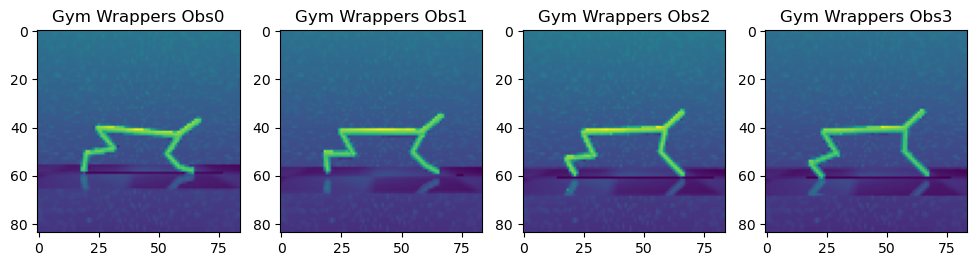

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


def experiment(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(100):
        obs, _, _, _, _ = env.step(np.random.uniform(low=-1.0, high=1.0, size=action_dim))
    
    return obs

obs = experiment(env)

plt.figure(figsize=(12, 8)) # 12 inches wide and 6 inch tall
for i in range(4):
    plt.subplot(1,4, i+1)
    plt.imshow(obs[i])
    plt.title(f'Gym Wrappers Obs{i}')

plt.show()


Experiment with Vectorized NumpyTorch 

In [ ]:
from gymnasium.vector import SyncVectorEnv
from gymnasium.wrappers.vector import NumpyToTorch
from gymnasium.vector import VectorWrapper, VectorEnv
from gymnasium.core import ActType, ObsType
from gymnasium.vector.vector_env import ArrayType
from typing import Any


num_envs = 4
env_id = 'HalfCheetah-v5'
device1 = torch.device('mps')
device2 = torch.device('cpu')

class NumpyToTorchMPSVec(VectorWrapper):
    """Wraps a numpy-based vector environment so that it can be interacted with through PyTorch Tensors on MPS.
    """

    def __init__(self, env: VectorEnv, device: str | torch.device = "mps"):
        """Wrapper class to change inputs and outputs of the environment to PyTorch tensors for MPS.

        Args:
            env: The numpy-based vector environment to wrap
            device: The device (e.g., "mps") the torch Tensors should be moved to
        """
        super().__init__(env)
        self.device: torch.device = torch.device(device)

    def step(
        self, actions: ActType
    ) -> tuple[ObsType, ArrayType, ArrayType, ArrayType, dict]:
        """Converts PyTorch-based actions to NumPy and returns PyTorch-based results.

        Args:
            actions: A PyTorch-based action tensor

        Returns:
            PyTorch-based Tensor next observation, reward, termination, truncation, and extra info
        """
        # Convert PyTorch tensor actions to NumPy
        np_actions = actions.cpu().numpy()
        obs, reward, terminated, truncated, info = self.env.step(np_actions)

        # Convert results back to PyTorch tensors on MPS
        return (
            torch.as_tensor(obs, dtype=torch.float32, device=self.device),
            torch.as_tensor(reward, dtype=torch.float32, device=self.device),
            torch.as_tensor(terminated, dtype=torch.bool, device=self.device),
            torch.as_tensor(truncated, dtype=torch.bool, device=self.device),
            self._to_torch(info),
        )

    def reset(
        self,
        *,
        seed: int | list[int] | None = None,
        options: dict[str, Any] | None = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """Resets the environment and returns PyTorch-based results.

        Args:
            seed: The seed for resetting the environment
            options: The options for resetting the environment

        Returns:
            PyTorch-based observations and info
        """
        if options:
            options = self._to_numpy(options)

        # Reset environment and convert results to PyTorch tensors
        obs, info = self.env.reset(seed=seed, options=options)
        return self._to_torch(obs), self._to_torch(info)

    def _to_torch(self, value):
        """Helper function to convert NumPy values to PyTorch tensors."""
        if isinstance(value, np.ndarray):
            return torch.tensor(value, dtype=torch.float32, device=self.device)
        elif isinstance(value, dict):
            return {k: self._to_torch(v) for k, v in value.items()}
        elif isinstance(value, (list, tuple)):
            return type(value)(self._to_torch(v) for v in value)
        return value

    def _to_numpy(self, value):
        """Helper function to convert PyTorch tensors back to NumPy."""
        if isinstance(value, torch.Tensor):
            return value.cpu().numpy()
        elif isinstance(value, dict):
            return {k: self._to_numpy(v) for k, v in value.items()}
        elif isinstance(value, (list, tuple)):
            return type(value)(self._to_numpy(v) for v in value)
        return value

def create_env_preprocess_func(env_id):
        def _init():
            env = dmc2gym.DMCWrapper(domain_name="cheetah", task_name="run", rendering='egl', frame_skip=4, from_pixels=True, height=84, width=84)
            env = PreprocessObservation(env)
            env = FrameStackObservation(env, stack_size=4)
            return env
        return _init

def experiment(env):
    env.reset()

    action_dim = env.action_space.shape

    for i in range(10):
        obs, reward, _, _, _ = env.step(torch.empty(size=action_dim, dtype=torch.float32).uniform_(-1, 1))
    
    return obs, reward

envs1 = SyncVectorEnv([create_env_preprocess_func(env_id) for _ in range(num_envs)]) 
envs1 = NumpyToTorchMPSVec(envs1, device1)
envs2 = SyncVectorEnv([create_env_preprocess_func(env_id) for _ in range(num_envs)]) 
envs2 = NumpyToTorchMPSVec(envs2, device2)
print(envs1.observation_space, envs1.num_envs)

time1 = timeit.timeit(lambda: experiment(envs1), number=100)
time2 = timeit.timeit(lambda: experiment(envs2), number=100)

print(f"MPS Pixels Env execution: {time1:.4f} seconds")
print(f"CPU Pixels Env execution: {time2:.4f} seconds") # well that's pathetic aaaa
### Comparison to similar gymnasium setup
#MPS Pixels Env execution: 15.8182 seconds => 14.26 egl(10% faster) | glf -14.7
#CPU Pixels Env execution: 14.5051 seconds => 12.92 egl(12$% faster) | glf -12.8
# In the end it all looks like similar perfomanace